## GradientBoostingRegressor from SAS® Viya® on Bike Sharing Demand
### Source
This example has been adapted from [EDA & Ensemble Model (Top 10 Percentile)](https://www.kaggle.com/code/viveksrinivasan/eda-ensemble-model-top-10-percentile/notebook) by Vivek Srinivasan.

### Data Preparation
#### About the data set

A bicycle sharing system is a system of linked rental locations throughout a metropolitan area that allows individuals to share a pool of bicycles for their use. Bicycles rented from one location may be returned to any other location in the network.  Joining the network and renting or returning bicycles are automated. As of 2022, there are around 3000 cities offering such systems.

The data set contains information about the number of bikes rented by different types of users over several years tracked by hour. Additional information about each rental period includes weather information and categorization of the type of day.

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#### Importing the data

In [2]:
workspace=f'{os.path.abspath("")}/../data/'
bikeData = pd.read_csv(workspace + "bike_sharing_demand.csv")
bikeData.shape

(17379, 16)

#### Sample of the first few rows

In [3]:
bikeData.head(5)

,date,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1/1/2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1/1/2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1/1/2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,1/1/2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,1/1/2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### Variable data types

In [4]:
bikeData.dtypes

date           object
season          int64
year            int64
month           int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

### Data Analysis

The information above shows the columns "hour", "weekday", "month", "season", "holiday", "workingday", and "weather" as Int64 when they should be a categorical type.  We will coerce those columns from integers into appropriate categorical types. In addition, we will drop the date column.

#### Coercing to categorical types and dropping unnecessary columns

In [5]:
bikeData["month"] = bikeData.month.map({1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",7:"July",
                                         8:"August",9:"September",10:"October",11:"November",12:"December"})
bikeData["weekday"] = bikeData.weekday.map({0:"Sunday",1:"Monday",2:"Tuesday",3:"Wednesday",4:"Thursday",5:"Friday",6:"Saturday"})
bikeData["season"] = bikeData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
bikeData["weather"] = bikeData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })
bikeData["workingday"] = bikeData.workingday.map({0: "Non-Working Day", 1: "Working Day"})

In [6]:
categoryVariableList = ["hour","weekday","month","season","holiday","workingday","weather"]
for var in categoryVariableList:
    bikeData[var] = bikeData[var].astype("category")
bikeData  = bikeData.drop(["date"],axis=1)

### Outlier Analysis

#### Visualizing the outliers

In order to get a sense of how outliers may be distributed in the data, we will run a series of boxplots for "count" by itself and "count" versus "season", "hour", and "workingday".

The plots allow us to draw the following inferences about the data:
* "count" contains many outliers beyond the upper quartile limit which skew the distribution towards higher values.
* For "season", Spring has a relatively lower of "count" demonstrated by the lower median value in its boxplot.
* The boxplot for "Hour Of The Day" has relatively higher median values for 0700, 0800, 1700, and 1800 hours.  This likely matches up with commuter traffic for the start and end of school and office workdays.
* "Working Day" observations contribute a majority of the outliers, as opposed to "Non-Working Day" ones.

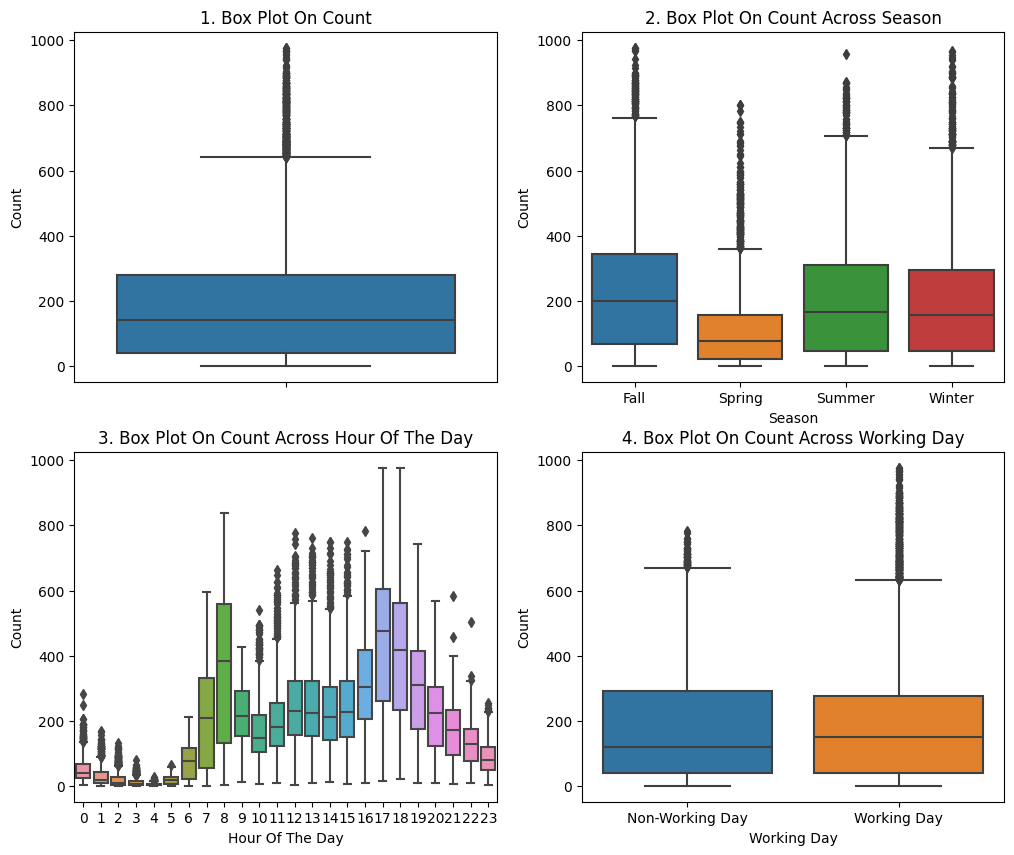

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=bikeData,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=bikeData,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=bikeData,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=bikeData,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="1. Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="2. Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="3. Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="4. Box Plot On Count Across Working Day");

#### Removing outliers in the count variable

In [8]:
bikeDataWithoutOutliers = bikeData[np.abs(bikeData["count"]-bikeData["count"].mean())<=(3*bikeData["count"].std())]

print ("Shape of the data with outliers: ",bikeData.shape)
print ("Shape of the data without outliers: ",bikeDataWithoutOutliers.shape)

Shape of the data with outliers:  (17379, 15)
Shape of the data without outliers:  (17135, 15)


### Correlation Analysis
A common method for understanding numeric variables influence dependent variables is through constructing a correlation matrix.  We will specifically examine the correlation of "count" versus "temp", "atemp", "humidity", and "windspeed".

#### Viewing a heatmap
From examining the heatmap, we can notice:

* "temp" and "humidity" have a positive and negative correlation with "count", respectively. Since the values are noticeably large, "count" does not depend much on either.
* As "windspeed" has a very low correlation with "count", it adds little to the analysis. 
* Since "atemp" (measurement of what the temperature "feels like") and "temp" (thermometer reading) have a strong correlation with each other, including them both would introduce multicollinearity into the analysis. With those definitions, one would expect this relationship and so "atemp" will be dropped.
* As "casual" and "registered" are leakage variables in nature, they should also be dropped.

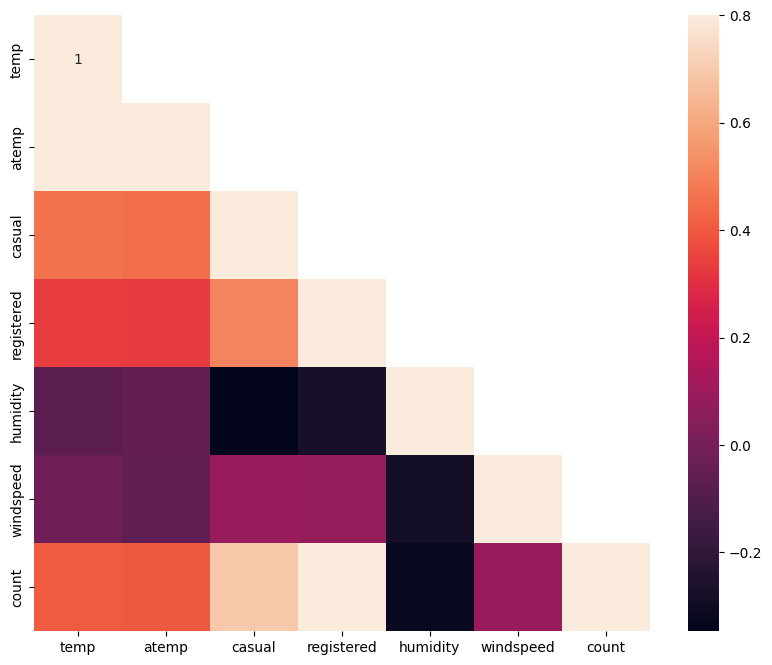

In [9]:
corrMatt = bikeData[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(10,8)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True);

#### Regression plots
Regression plots from `seaborn` are a useful way to depict the relationship between two features. We will also view these for "count" versus "temp", "atemp", "humidity", and "windspeed".

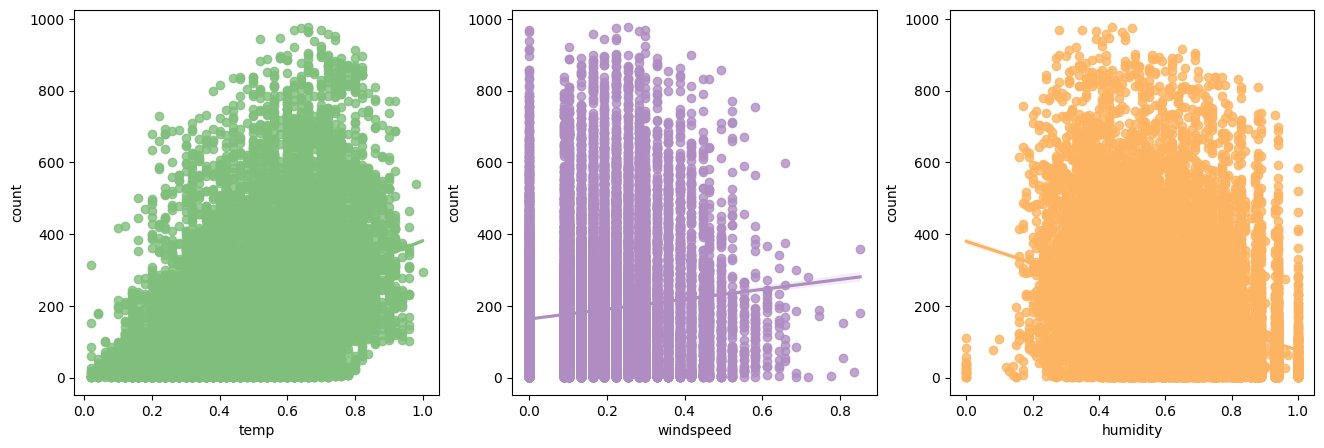

In [10]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(16, 5)

# Assigning softer colors to each plot
color1 = "#7fbf7b"  # Light green
color2 = "#af8dc3"  # Light purple
color3 = "#fdb462"  # Light orange

sn.regplot(x="temp", y="count", data=bikeData,ax=ax1, color=color1)
sn.regplot(x="windspeed", y="count", data=bikeData,ax=ax2, color=color2)
sn.regplot(x="humidity", y="count", data=bikeData,ax=ax3, color=color3);

### Visualizing the Distribution of Data
As is visible from the figures below, "count" is skewed towards the right and not a normal distribution.  Since many machine learning algorithms require a normal distribution, we will need to pursue options to address this.  A common technique is to take a log transformation of "count" after removing the outliers. Afterwards, the data distribution looks better but is still not an ideal normal.

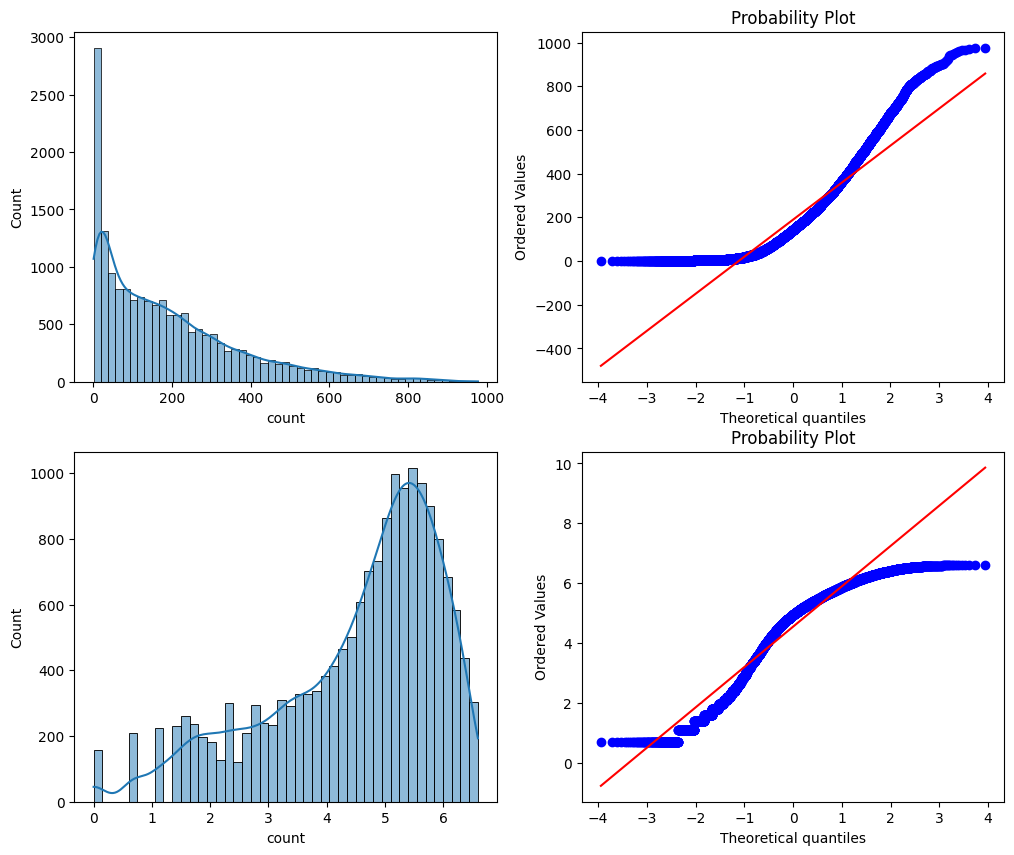

In [11]:
from scipy import stats
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.histplot(x = bikeData["count"], kde = True, ax = axes[0,0])
stats.probplot(bikeData["count"], dist='norm', fit=True,plot=axes[0][1] )
sn.histplot(x = np.log(bikeDataWithoutOutliers["count"]), kde = True, ax = axes[1,0])
stats.probplot(np.log1p(bikeDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])
fig.show()

### Visualizing Count Versus Month, Season, Hour, and Weekday
The plots help show:
* People tend to rent bikes during summer leading June, July, and August to have relatively higher "count" (demand).
* On weekdays, more people rent bicycles for the 0700, 0800, 1700, and 1800 hours. This overlaps with normal school and office schedules.
* The renters during this time are registered users.
* On weekend days, more bicycles are rented between 1000 and 1600.  

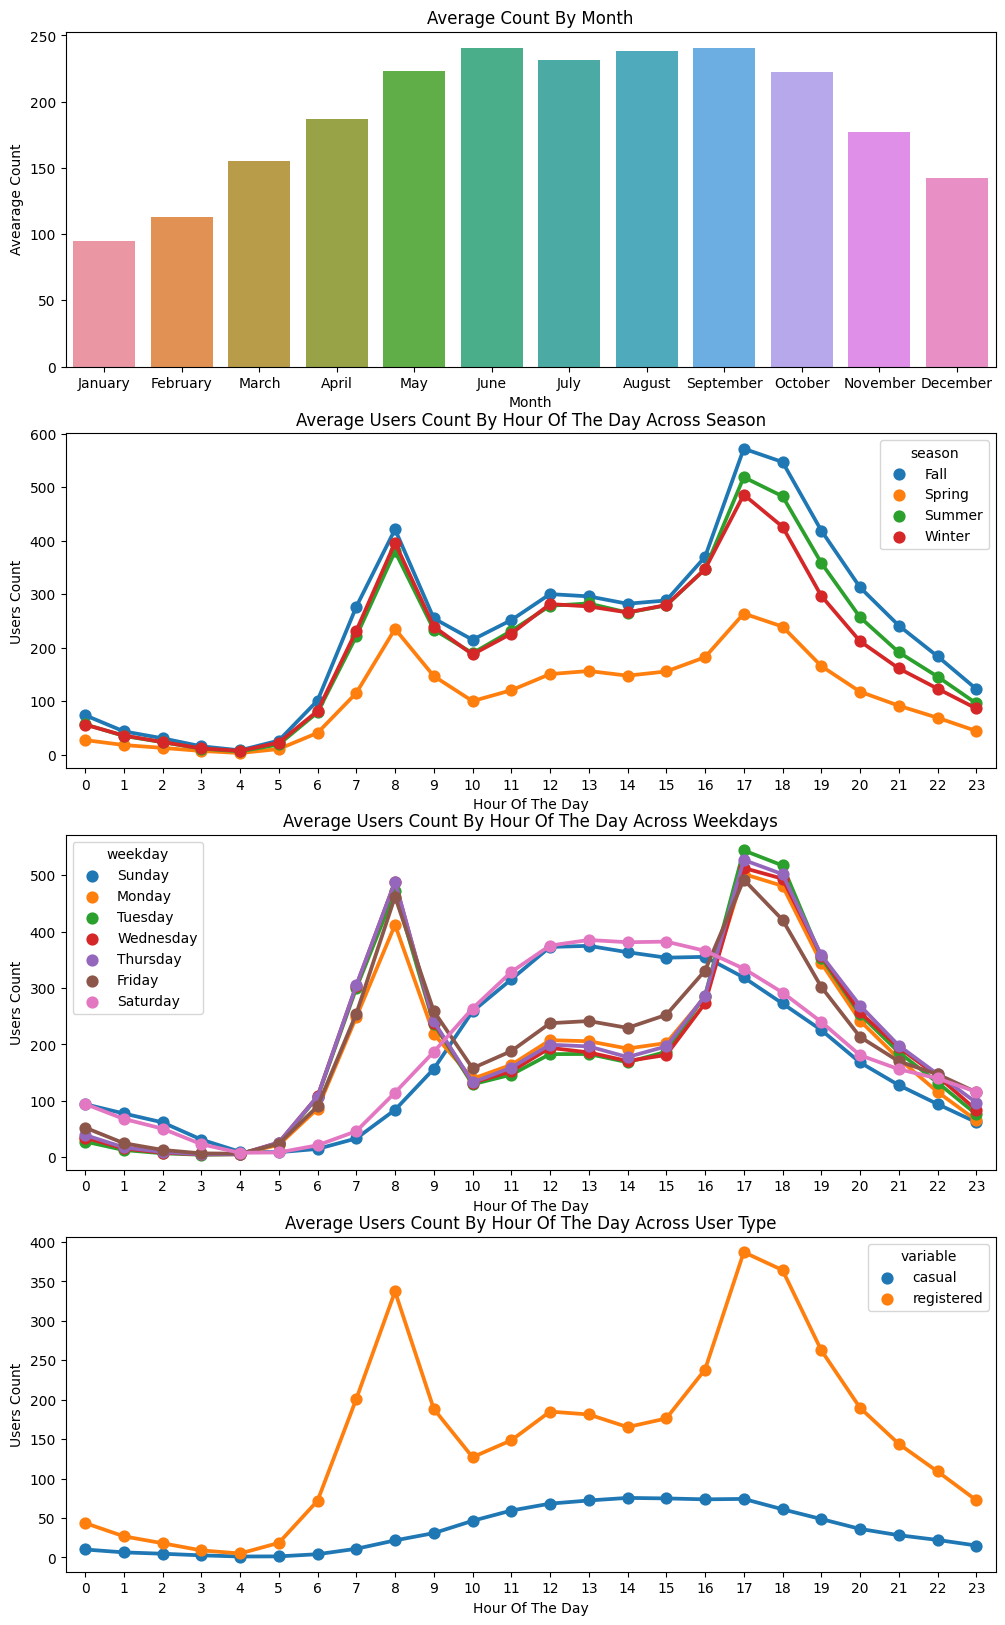

In [12]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(bikeData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(bikeData.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(bikeData.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(bikeData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')
fig.show()

### Integrating Data Discoveries
After this visualization, we will integrate our discoveries about the data in our preparation for the analysis.

In [13]:
bikeData = pd.read_csv(workspace + "bike_sharing_demand.csv")

#### Defining feature lists

In [14]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ["casual","date","registered"]

#### Dropping unncessary variables

In [15]:
bikeData  = bikeData.drop(dropFeatures,axis=1)

#### Creating training and test data
We split the original data by putting 75% into the training set and 25% into the test set. 

In [16]:
X = bikeData.drop('count', axis=1)
Y = bikeData['count']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=3)

### Ensemble Models - Gradient Boosting

For details about using the `GradientBoostingRegressor` class of the `sasviya` package, see the [GradientBoostingRegressor documentation](https://documentation.sas.com/?cdcId=workbenchcdc&cdcVersion=default&docsetId=explore&docsetTarget=p1qf6527qwg4g5n179gglp8xzlgi.htm).

In [17]:
from sasviya.ml.tree import GradientBoostingRegressor

gbModel = GradientBoostingRegressor(n_estimators=100,
                                    max_depth=10,
                                    min_samples_leaf=1,
                                    max_features=None,
                                    learning_rate=0.1,
                                    subsample = 1.0,
                                    random_state=0)

gbModel.fit(X_train, y_train, nominals = categoricalFeatureNames)
print("Gradient Boosting Regressor -Test Set Score: {:.2f}".format(gbModel.score(X_test, y_test)))

Gradient Boosting Regressor -Test Set Score: 0.95
